# This is a demo of how load to MNIST raw pngs manually without torchvision and use torch for neural network machine learning

## Run the following for Google colab 
then restart runtime

In [37]:
! pip install --upgrade --no-cache-dir https://github.com/manassharma07/crysx_nn/tarball/main
! pip install IPython==7.7.0

^C
  Using cached ipython-7.7.0-py3-none-any.whl (774 kB)
  Using cached prompt_toolkit-2.0.10-py3-none-any.whl (340 kB)
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.20
    Uninstalling prompt-toolkit-3.0.20:
      Successfully uninstalled prompt-toolkit-3.0.20
  Attempting uninstall: IPython
    Found existing installation: ipython 7.29.0
    Uninstalling ipython-7.29.0:
      Successfully uninstalled ipython-7.29.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipykernel 6.4.1 requires ipython<8.0,>=7.23.1, but you have ipython 7.7.0 which is incompatible.


In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from crysx_nn import mnist_utils as mu
import numpy as np

## Download MNIST_orig and MNIST_orig dataset (May take upto 5 min)

In [2]:
%%time
mu.downloadMNIST()

Wall time: 2min 49s


## Load the training dataset from MNIST_orig in memory (May take upto 5 min)

In [2]:
%%time
path = 'MNIST-PLUS-PNG/mnist_orig_png'
trainData, trainLabels = mu.loadMNIST(path_main=path, train=True, shuffle=True)

Wall time: 3min 26s


In [3]:
print('Training data shape', trainData.shape)
print('Training labels shape',trainLabels.shape)
print('Size of training data in memory (GB)', trainData.nbytes/1024/1024/1024)

Training data shape (60000, 28, 28)
Training labels shape (60000, 1)
Size of training data in memory (GB) 0.3504753112792969


In [4]:
# Statistics
print(trainData.min()) # Expected for MNIST_orig: 0.0
print(trainData.max()) # Expected for MNIST_orig: 255.
print(trainData.mean()) # Expected for MNIST_orig: 33.31842144
print(trainData.std()) # Expected for MNIST_orig: 78.567489983

0.0
255.0
33.318421449829934
78.56748998339812


## Normalize within the range [0,1.0]

In [5]:
trainData = trainData/255 # Normalize
# Statistics
print(trainData.min()) # Expected for MNIST_orig: 0.0
print(trainData.max()) # Expected for MNIST_orig: 1.0
print(trainData.mean()) # Expected for MNIST_orig: 0.1306604762738426
print(trainData.std()) # Expected for MNIST_orig: 0.3081078038564622 

0.0
1.0
0.13066047627384245
0.3081078038564627


## Standardize the data so that it has mean 0 and variance 1

In [6]:
trainData = (trainData - np.mean(trainData)) / np.std(trainData)
# Statistics
print(trainData.min()) # Expected for MNIST_orig: -0.42407
print(trainData.max()) # Expected for MNIST_orig: 2.8215433
print(trainData.mean()) # Expected for MNIST_orig: 0.0
print(trainData.std()) # Expected for MNIST_orig: 1.0000

-0.42407389439156457
2.8215433456893364
1.3693690172718859e-15
0.9999999999999994


## Convert labels to one-hot vectors

In [7]:
print(trainLabels)
trainLabels = mu.one_hot_encode(trainLabels, 10)
print(trainLabels)

[[9.]
 [6.]
 [8.]
 ...
 [9.]
 [2.]
 [9.]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## Convert numpy arrays to torch tensors

In [8]:
import torch
trainData_torch = torch.Tensor(trainData).float()
trainLabels_torch = torch.Tensor(trainLabels).float()

## Let us train a NN now

In [10]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

### Define the dense neuron layer
# Network = torch.nn.Sequential(
#     torch.nn.Flatten(),            # 28x28 -> 784
#     torch.nn.Linear(784, 10),      # 784 -> 10
#     torch.nn.Softmax(dim=1)
# )
Network = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.Softmax(dim=1)
)
Network.to(device=device)

### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
crit = torch.nn.BCELoss()
# crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=0.4)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): Softmax(dim=1)
)
203530 trainable parameters


In [11]:
### Baseline: just say it's anything at probability 1/N, what's the loss?
N = 10
labels = torch.zeros(1, 10, dtype=torch.float32)
labels[0, 3] = 1.
output = torch.full_like(labels, 1./N)
print(crit(output, labels))

tensor(0.3251)


In [13]:
batchSize = 32
nBatches = trainData_torch.shape[0]//batchSize
print(nBatches)

1875


In [14]:
from tqdm.notebook import tqdm
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, 16)

errorPlot = []

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for iBatch in tqdm(range(nBatches),leave=False):
        offset = iBatch*batchSize
        inputsBatch = trainData_torch[offset:offset + batchSize,:,:]# Input vector
#            print(x.shape)
        labelsBatch = trainLabels_torch[offset:offset + batchSize,:] # Expected output
        
        opt.zero_grad() # zero gradient values
        inputsBatch = inputsBatch.to(device=device) # move input and label tensors to the device with the model
        labelsBatch = labelsBatch.to(device=device)
        outputsTorch = Network(inputsBatch) # compute model outputs
        loss = crit(outputsTorch, labelsBatch) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputsBatch) # add the batch loss to the running loss
        samples += len(inputsBatch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
    print(e, tr_loss)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

1 0.03997602404827873


  0%|          | 0/1875 [00:00<?, ?it/s]

2 0.01747313653031985


  0%|          | 0/1875 [00:00<?, ?it/s]

3 0.011722353303510074


  0%|          | 0/1875 [00:00<?, ?it/s]

4 0.008370682490159136


  0%|          | 0/1875 [00:00<?, ?it/s]

5 0.006076743150137676


  0%|          | 0/1875 [00:00<?, ?it/s]

6 0.004440798512339825


  0%|          | 0/1875 [00:00<?, ?it/s]

7 0.003224570000906048


  0%|          | 0/1875 [00:00<?, ?it/s]

8 0.0023718173806225725


  0%|          | 0/1875 [00:00<?, ?it/s]

9 0.0017967171865137061


  0%|          | 0/1875 [00:00<?, ?it/s]

10 0.001372928347119887


  0%|          | 0/1875 [00:00<?, ?it/s]

11 0.0010565379780557123


  0%|          | 0/1875 [00:00<?, ?it/s]

12 0.0008247575965511108


  0%|          | 0/1875 [00:00<?, ?it/s]

13 0.0006567718180131729


  0%|          | 0/1875 [00:00<?, ?it/s]

14 0.0005389578022506611


  0%|          | 0/1875 [00:00<?, ?it/s]

15 0.0004563055216545763


## Test data set

In [15]:
path = 'MNIST-PLUS-PNG/mnist_orig_png'
testData, testLabels = mu.loadMNIST(path_main=path, train=False, shuffle=True)

print('Test data shape', testData.shape)
print('Test labels shape',testLabels.shape)
print('Size of training data in memory (GB)', testData.nbytes/1024/1024/1024)

# Statistics
print(testData.min()) # Expected for MNIST_orig: 0.0
print(testData.max()) # Expected for MNIST_orig: 255.
print(testData.mean()) # Expected for MNIST_orig: 33.31842144
print(testData.std()) # Expected for MNIST_orig: 78.567489983

## Normalize within the range [0,1.0]

testData = testData/255 # Normalize
# Statistics
print(testData.min()) # Expected for MNIST_orig: 0.0
print(testData.max()) # Expected for MNIST_orig: 1.0
print(testData.mean()) # Expected for MNIST_orig: 0.1306604762738426
print(testData.std()) # Expected for MNIST_orig: 0.3081078038564622 

## Standardize the data so that it has mean 0 and variance 1
# Use the mean and std of training data **********
testData = (testData - np.mean(trainData)) / np.std(trainData)
# Statistics
print(testData.min()) # Expected for MNIST_orig: -0.42407
print(testData.max()) # Expected for MNIST_orig: 2.8215433
print(testData.mean()) # Expected for MNIST_orig: 0.0
print(testData.std()) # Expected for MNIST_orig: 1.0000

## Convert labels to one-hot vectors
print(testLabels)
testLabels = mu.one_hot_encode(testLabels, 10)
print(testLabels)

## Convert numpy arrays to torch tensors
testData_torch = torch.Tensor(testData).float()
testLabels_torch = torch.Tensor(testLabels).float()


Test data shape (10000, 28, 28)
Test labels shape (10000, 1)
Size of training data in memory (GB) 0.05841255187988281
0.0
255.0
33.791224489795916
79.17246322228645
0.0
1.0
0.132514605842337
0.3104802479305351
-1.3693690172718867e-15
0.9999999999999992
0.13251460584233574
0.3104802479305353
[[6.]
 [1.]
 [7.]
 ...
 [1.]
 [1.]
 [4.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Performance on Test data

In [16]:
batchSize = 32
nBatches = testData_torch.shape[0]//batchSize
print(nBatches)

312


In [17]:
### Set model in evaluation mode
Network.eval()

### Compute the test loss
with torch.no_grad():
    te_loss = 0.
    samples = 0
    accuracy = 0
     ### Loop over batches
    for iBatch in tqdm(range(nBatches),leave=False):
        offset = iBatch*batchSize
        inputs = testData_torch[offset:offset + batchSize,:,:]# Input vector
#            print(x.shape)
        labels = testLabels_torch[offset:offset + batchSize,:] # Expected output
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = Network(inputs)
        loss = crit(outputs, labels)
        te_loss += loss.clone().cpu().item()*len(inputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs)
    te_loss /= samples
    accuracy /= samples
    print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))

  0%|          | 0/312 [00:00<?, ?it/s]

Test loss: 0.034478, accuracy: 0.971955


## Interactive test

(135, 125)
(145, 135)
5 5

tensor([[5.0069e-05, 2.1358e-03, 9.9049e-01, 7.2195e-03, 5.9724e-09, 1.0199e-04,
         6.5823e-08, 4.8332e-06, 1.2912e-07, 7.9045e-08]])
2
tensor([0.9905, 0.0072, 0.0021])
tensor([2, 3, 1])


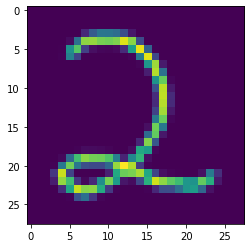

In [34]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
import cv2

width = 200  # canvas width
height = 200 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    filename = "user_input.png"
    global output_image 
    output_image.save(filename)
    ###### Centering begin
    # Load image as grayscale and obtain bounding box coordinates
    image = cv2.imread('user_input.png', 0)
    height, width = image.shape
    x,y,w,h = cv2.boundingRect(image)


    # Create new blank image and shift ROI to new coordinates
    ROI = image[y:y+h, x:x+w]
    mask = np.zeros([ROI.shape[0]+10,ROI.shape[1]+10])
    width, height = mask.shape
    print(ROI.shape)
    print(mask.shape)
    x = width//2 - ROI.shape[0]//2 
    y = height//2 - ROI.shape[1]//2 
    print(x,y)
    mask[y:y+h, x:x+w] = ROI

    # Check if centering/masking was successful
#     plt.imshow(mask, cmap='viridis') 
    output_image = PIL.Image.fromarray(mask) # mask has values in [0-255] as expected
    # Now we need to resize, but it causes problems with default arguments as it changes the range of pixel values to be negative or positive
    # compressed_output_image = output_image.resize((22,22))
    # Therefore, we use the following:
    compressed_output_image = output_image.resize((22,22), PIL.Image.BILINEAR) # PIL.Image.NEAREST or PIL.Image.BILINEAR also performs good
#     # Enhance Saturation
#     converter = PIL.ImageEnhance.Color(compressed_output_image)
#     compressed_output_image = converter.enhance(2.5)
    # Enhance contrast
#     converter = PIL.ImageEnhance.Contrast(compressed_output_image)
#     compressed_output_image = converter.enhance(3.5)
    convert_tensor = torchvision.transforms.ToTensor()
    tensor_image = convert_tensor(compressed_output_image)
    # Another problem we face is that in the above ToTensor() command, we should have gotten a normalized tensor with pixel values in [0,1]
    # But somehow it doesn't happen. Therefore, we need to normalize manually
    tensor_image = tensor_image/255.
    # Padding
    tensor_image = torch.nn.functional.pad(tensor_image, (3,3,3,3), "constant", 0)
    # Normalization shoudl be done after padding i guess
    convert_tensor = torchvision.transforms.Normalize((0.1307), (0.3081))
    tensor_image = convert_tensor(tensor_image)
    plt.imshow(tensor_image.detach().cpu().numpy().reshape(28,28), cmap='viridis')
    # Debugging
#     print(tensor_image)
#     print(np.array(compressed_output_image.getdata())) # Get data values)
#     print(np.array(image.getdata()))

    ### Compute the predictions
    print()
    with torch.no_grad():
#         print(tensor_image)
        output0 = Network(torch.unsqueeze(tensor_image, dim=0).to(device=device))
        print(output0)
        certainty, output = torch.max(output0[0], 0)
        certainty = certainty.clone().cpu().item()
        output = output.clone().cpu().item()
        certainty1, output1 = torch.topk(output0[0],3)
        certainty1 = certainty1.clone().cpu()#.item()
        output1 = output1.clone().cpu()#.item()
#     print(certainty)
    print(output)
        
    print(certainty1)
    print(output1)

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
#     canvas.create_oval(x1, y1, x2, y2, fill="white",width=24)
    canvas.create_rectangle(x1, y1, x2, y2, fill="white",width=12)
    draw.line([x1, y1, x2, y2],fill="white",width=6)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("L", (width, height), 0)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="save",command=save)
button.pack()

master.mainloop()